In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Bring in raw data and treatment index

In [5]:
#Function to extract pot ID out of sample name
def Convert1(x):
    value = x.split(' ')[0]
    if value in ['Otane','NT','IRC','extra','BW']:
        return np.nan
    else:
        return int(value)
#Bring in raw Date
qPCRdt_date1 = pd.read_csv('./Pilot2014/Sampledat1_raw.csv')
#Convert plate ID to a string to be consitent with sample date 3
qPCRdt_date1.loc[:,'plate'] = ['plate' + str(qPCRdt_date1.loc[x,'plate']) + qPCRdt_date1.loc[x,'geno_set'] for x in qPCRdt_date1.index]
#remove column which was included into plate ID above
qPCRdt_date1.drop('geno_set',axis=1,inplace=True)
#parse Sample ID out of Sample name
qPCRdt_date1.loc[:,'SampleID'] = [Convert1(qPCRdt_date1.loc[x,'SampleName']) for x in qPCRdt_date1.index]
#Set a date identifier
qPCRdt_date1.loc[:,'SampleDate'] = dt.date(2013,12,16)

#Function to extract pot ID out of sample name
def Convert3(x):
    value = x.split(' ')[1]
    if value in ['CAL','T']:
        return np.nan
    else:
        return int(value)
qPCRdt_date3 = pd.read_csv('./Pilot2014/Sampledate3_raw.csv')
#Bring in the Raw Data
qPCRdt_date3.loc[:,'SampleID'] = [Convert3(qPCRdt_date3.loc[x,'SampleName']) for x in qPCRdt_date3.index]
#Set a date identifier
qPCRdt_date3.loc[:,'SampleDate'] = dt.date(2014,1,15)

#Join sample date 1 and 3 into a single data frame
qPCRdt = pd.concat([qPCRdt_date1,qPCRdt_date3])
qPCRdt.index = range(qPCRdt.index.size)

#fix the date format
qPCRdt.SampleDate = pd.to_datetime(qPCRdt.SampleDate)

#Bring in the experiment data so we can assign sample time and cultivars to each sample
ExperimentIndex = pd.read_excel('./Pilot2014/Biotron design Pilot.xlsx',sheet_name='DataIndex')

#Join the treatment data in to the qPCR data frame
for i in qPCRdt.index:
    if np.isnan(qPCRdt.SampleID[i]):
        qPCRdt.loc[i,'Genotype'] = np.nan
        qPCRdt.loc[i,'SampleTime'] = np.nan
    else:
        date = qPCRdt.SampleDate[i]
        pot = qPCRdt.SampleID[i]
        TreatFilter = (ExperimentIndex.loc[:,'Sample Date'] == date) & (ExperimentIndex.PotUniqueID==pot)
        qPCRdt.loc[i,'Genotype'] = ExperimentIndex.loc[TreatFilter,'Wheat Cultivar'].values[0]
        qPCRdt.loc[i,'SampleTime'] = ExperimentIndex.loc[TreatFilter,'Sampling Time'].values[0]
        
#Make a unique identifier for each leaf sample
qPCRdt.loc[:,'Sample'] = [dt.date.strftime(qPCRdt.SampleDate[x],'%Y-%m-%d') + '_' + str(qPCRdt.SampleID[x]) for x in qPCRdt.index]

## Make a dataframe with reference reads in it

In [6]:
RefReads = qPCRdt.loc[(qPCRdt.Task=='IRC')]
NTC = qPCRdt.loc[(qPCRdt.Task=='NTC')]

## Remove Reference reads and NTC from main data frame

In [7]:
qPCRdt.drop(RefReads.index,inplace=True)
qPCRdt.drop(NTC.index,inplace=True)

## Make some lists of things

In [8]:
Samples = list(set(qPCRdt.Sample))
Dates = ['2013-12-16', '2014-01-15']
Genes = ['VRN1', 'VRN2', 'VRN3','EGF1a', 'Ta54227']
Cults = ['Otane',
         'Batten Spr',
         'Saracen',
         'Batten Win'] #Specify cultivar list manually to set in maturity order

## Make a dataframe with the mean Cp values for each gene in each sample

In [9]:
HouseKeepers = pd.DataFrame(columns = Genes)
for Samp in Samples:
    Cps = []
    for Gene in Genes:
        Cps.append(qPCRdt.loc[qPCRdt.Sample==Samp].loc[qPCRdt.TargetName == Gene,'Ct'].mean())
    HouseKeepers.loc[Samp,:]=Cps

## Check corelation of genes

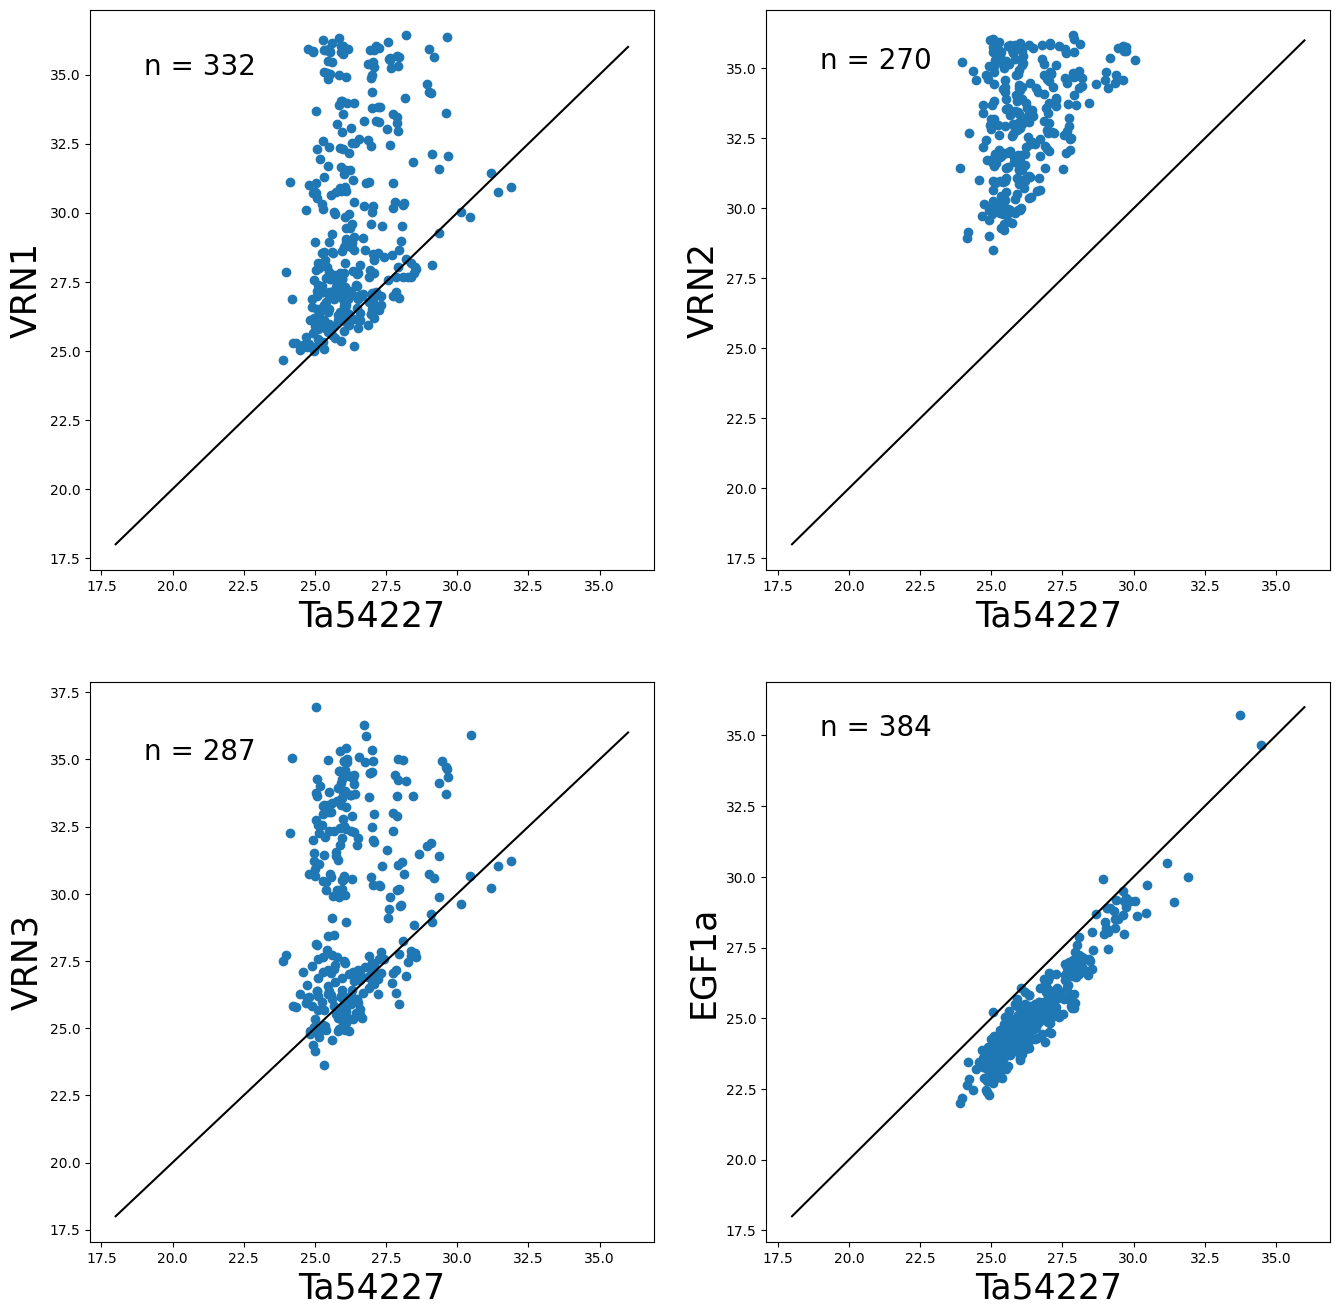

In [10]:
Fig = plt.figure(figsize=(16,16))
pos = 1
for Gene in Genes[:-1]:
    ax = Fig.add_subplot(2,2,pos)
    plt.plot(HouseKeepers.Ta54227,HouseKeepers.loc[:,Gene],'o')
    plt.ylabel(Gene,fontsize=25)
    plt.xlabel('Ta54227',fontsize=25)
    plt.plot([18,36],[18,36],'-',color='k')
    count = str(HouseKeepers.loc[:,Gene].dropna().size)
    plt.text(19,35,'n = ' + count, fontsize = 20)
    pos+=1
    

## Check plate references

In [12]:
#Make a data frame with the mean Cp values for each gene in each plate
RefCps = RefReads.groupby(['TargetName','plate']).mean('numeric_only').loc[:,'Ct'].to_frame()

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_13944\3434636761.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax = Fig.add_subplot(1,5,pos, xticklabels=RefCps.index.get_level_values(1).drop_duplicates())
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_13944\3434636761.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax = Fig.add_subplot(1,5,pos, xticklabels=RefCps.index.get_level_values(1).drop_duplicates())
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_13944\3434636761.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax = Fig.add_subplot(1,5,pos, xticklabels=RefCps.index.get_level_values(1).drop_duplicates())
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_13944\3434636761.py:7: UserWarning: set_ticklabels() should only be used with a

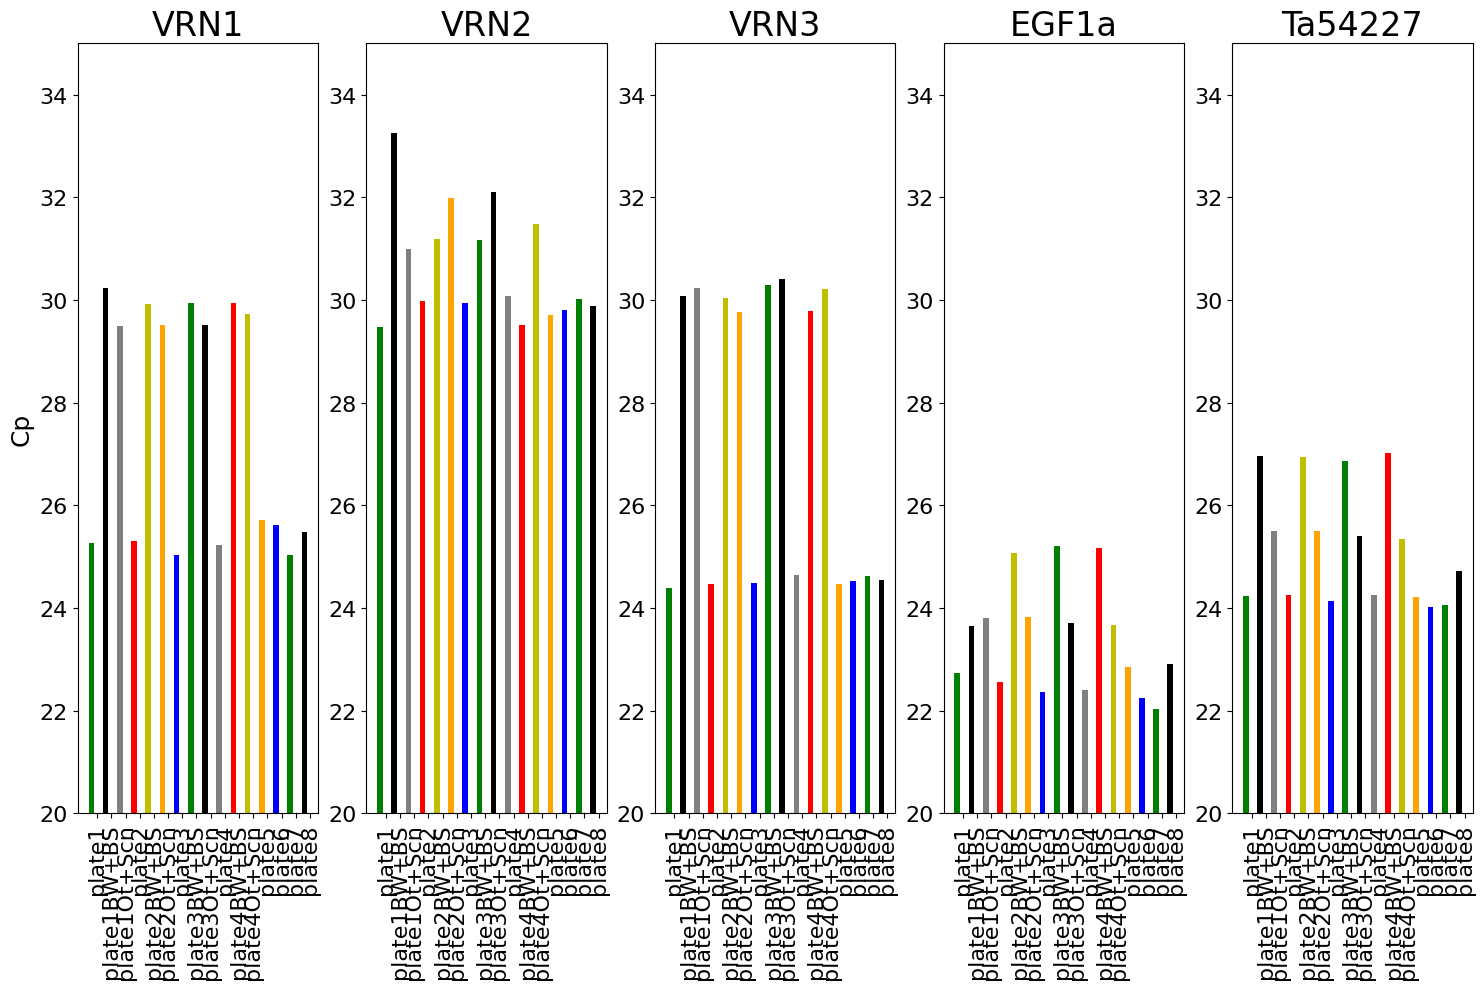

In [13]:
width = 0.4
ind = np.arange(16) + width
Fig = plt.figure(figsize=(18, 10))

pos = 1
for gene in Genes:
    ax = Fig.add_subplot(1,5,pos, xticklabels=RefCps.index.get_level_values(1).drop_duplicates())
    plt.bar(ind, RefCps.loc[gene,'Ct'],width,color=['g','k','grey','r','y','orange','b'])
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.tick_params(labelsize=16)
    plt.title(gene,fontsize = 24)
    plt.xticks(ind+width)
    plt.ylim(20,35)
    if pos == 1:
        plt.ylabel('Cp',fontsize=18)
    pos +=1

## Make a dataframe with normalisation factors to account for plat to plate variability

In [14]:
RefCps

Ct
TargetName plate                  
EGF1a      plate1        22.742769
           plate1BW+BS   23.656614
           plate1Ot+Scn  23.812863
           plate2        22.560845
           plate2BW+BS   25.066029
...                            ...
VRN3       plate4Ot+Scn  30.209394
           plate5        24.467535
           plate6        24.532817
           plate7        24.619253
           plate8        24.542707

[80 rows x 1 columns]

In [15]:
#Calculate the mean Cp for each gene across all plates
RefMeans = RefCps.groupby(level='TargetName').mean()
#Then calculate the Cp for each gene in each plate relative to 
#the mean for that gne across all plates
for ref in RefCps.index:
    RefCps.loc[ref,'NormFactor'] = RefMeans.loc[ref[0],'Ct']/RefCps.loc[ref,'Ct']

## Make a column in qPCRdt frame with normalised Cp values

In [16]:
for Obs in qPCRdt.index:
    Plate = qPCRdt.loc[Obs,'plate']
    Gene = qPCRdt.loc[Obs,'TargetName']
    NormFactor = RefCps.loc[(Gene,Plate),'NormFactor']
    qPCRdt.loc[Obs,'CpNorm'] = qPCRdt.loc[Obs,'Ct'] * NormFactor

## Make an index table so we can relate experimental data to sample name

In [17]:
#Slice out the coluns that hold experimental descriptors and drop duplicate rows
TreatIndex = qPCRdt.loc[qPCRdt.TargetName=='Ta54227',
          [u'Sample',u'SampleName', u'plate', u'SampleDate', u'SampleTime',
           u'SampleID', u'Genotype']].drop_duplicates().dropna(how='all')
#Make name the index for this dataframe
TreatIndex.set_index('Sample',inplace=True)

## Make dataframes with normalised expersion deltas

In [19]:
#Get means for each gene and then slice out the Cp data row
Intermediate = qPCRdt.groupby(['Sample','TargetName']).mean('numeric_only').loc[:,'CpNorm']
#Make into a table with name as index and Cp for each gene in columns
qPCRdtMeans = Intermediate.unstack()
#Make dataframes that subtract house keeper experssion from the genes
Tdelta = np.power(2,-qPCRdtMeans.loc[:,['VRN1','VRN2','VRN3','EGF1a']].subtract(qPCRdtMeans.loc[:,'Ta54227'],axis=0))
Edelta = np.power(2,qPCRdtMeans.loc[:,['VRN1','VRN2','VRN3','Ta54227']].subtract(qPCRdtMeans.loc[:,'EGF1a'],axis=0))

## Join the index info onto the delta dataframes

In [20]:
Td_ind = Tdelta.join(TreatIndex)
Td_ind.SampleDate = pd.to_datetime(Td_ind.SampleDate)
#Td_ind = Td_ind.where(Td_ind.isnull()==False,other=0)
Ed_ind = Edelta.join(TreatIndex)
Ed_ind.SampleDate = pd.to_datetime(Ed_ind.SampleDate)
#Ed_ind = Ed_ind.where(Ed_ind.isnull()==False,other=0)

In [21]:
Td_ind.set_index(['SampleDate','Genotype','SampleTime'],inplace=True,drop=False)
Td_ind.sort_index(inplace=True)

In [22]:
Ed_ind.set_index(['SampleDate','Genotype','SampleTime'],inplace=True,drop=False)
Ed_ind.sort_index(inplace=True)

In [25]:
Medians

VRN1      VRN2      VRN3     EGF1a  \
SampleDate Genotype   SampleTime                                           
2013-12-16 Batten Spr 0.0         0.717287  0.015329  0.064997  0.845215   
                      2.0         0.677427  0.016860  0.044271  0.680322   
                      4.0         0.732301  0.017467  0.064901  0.834021   
                      6.0         0.581653  0.004031  0.041971  3.119503   
                      8.0         0.459540  0.002801  0.051174  2.984024   
...                                    ...       ...       ...       ...   
2014-01-15 Saracen    14.0        0.009984  0.035322  0.001409  3.636441   
                      16.0        0.007933  0.027019  0.006319  2.880437   
                      18.0        0.004888  0.011204  0.001731  3.818416   
                      20.0        0.019823  0.001659  0.004717  3.674279   
                      22.0        0.000761  0.001574  0.000195  3.945043   

                                  SampleTime  SampleID  
SampleDate Genotype   SampleTime                        
2013-12-16 Batten Spr 0.0                0.0      76.5  
                      2.0                2.0     109.5  
                      4.0                4.0      96.5  
                      6.0                6.0      96.0  
                      8.0                8.0      97.5  
...                                      ...       ...  
2014-01-15 Saracen    14.0              14.0      98.5  
                      16.0              16.0     105.5  
                      18.0              18.0     109.0  
                      20.0              20.0     106.0  
                      22.0              22.0      95.0  

[96 rows x 6 columns]

C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_13944\3380243456.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  x = Td_ind.loc[(date,cult),'SampleTime'] + 2
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_13944\3380243456.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  y = Td_ind.loc[(date,cult),gene]
C:\Users\Cflhxb\AppData\Local\Temp\ipykernel_13944\3380243456.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


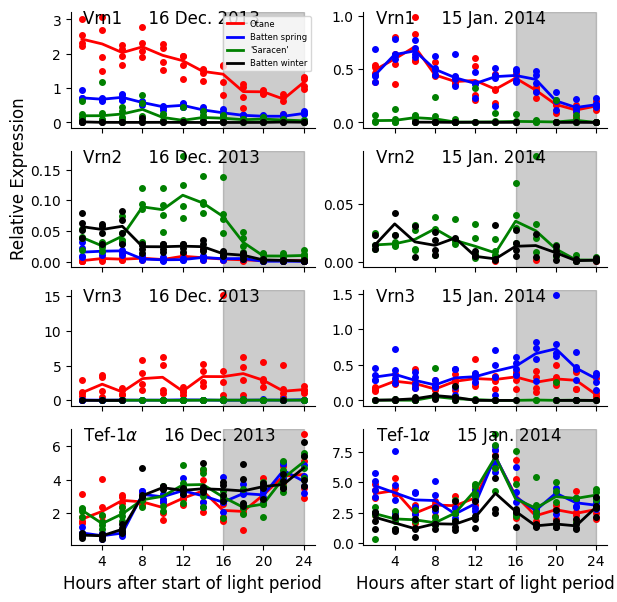

In [26]:
CultLabs = pd.DataFrame(index = Cults, data = ['Otane','Batten spring',"'Saracen'",'Batten winter'],columns=['name'])
GeneLabs = pd.DataFrame(index=Genes[:-1],columns=['Name'],data=['Vrn1','Vrn2','Vrn3',r'Tef-1$\alpha$'])
Colors = ['r','b','g','k']
Fig = plt.figure(figsize=(6.92,6.92))
pos = 1
Medians = Td_ind.groupby(level=['SampleDate','Genotype','SampleTime']).median('numeric_only')
for gene in Genes[:-1]:
    for date in Dates:
        ax = Fig.add_subplot(4,2,pos)
        colpos = 0
        lab = GeneLabs.loc[gene,'Name']
        plt.text(.05,.9,lab+ '     ' + dt.datetime.strptime(date,'%Y-%m-%d').strftime('%d %b. %Y'),
                 transform = ax.transAxes,fontsize=12)
        for cult in Cults:
            x = Td_ind.loc[(date,cult),'SampleTime'] + 2
            y = Td_ind.loc[(date,cult),gene]
            plt.plot(x,y,'o',color=Colors[colpos],label='_nolegend_',ms=4)
            plt.plot(Medians.loc[(date,cult),gene].index.get_level_values(0) + 2,Medians.loc[(date,cult),gene],
                     '-',color=Colors[colpos],lw=2,label=CultLabs.loc[cult,'name'])
            colpos+=1
        if pos == 1:
            leg = plt.legend(loc=1,fontsize=6)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
        plt.tick_params(axis='y', which='both', left=True,right=False, labelbottom=True,labelsize=10)
        plt.xticks([0,4,8,12,16,20,24])
        if pos <= 6:
            ax.tick_params(labelbottom=False)
        else:
            plt.xlabel('Hours after start of light period',fontsize=12)
        ax.tick_params(labelleft=False)
        #if pos in [1,3,5,7]:
        ax.tick_params(labelleft=True)
        pos += 1
        ax.axvspan(16,24,alpha=0.2,color='k')
        if pos == 9:
            plt.text(-1.45,2.5,'Relative Expression',transform = ax.transAxes,rotation=90,fontsize=12,)
            

plt.tight_layout()

Fig.savefig('C:\\Users\\cflhxb\\Dropbox\\WheatFlowering\\Fig2.jpg',format='jpg',dpi=300)     